# __[ 패스트캠퍼스] Model-based Methods__

# <br>__1. Data: NASA Bearing Dataset__

- 데이터 description <br>
    - NASA Bearing Dataset은 NSF I/UCR Center의 Intelligent Maintenance System의 4개의 bearing에서 고장이 발생할 때까지 10분 단위로 수집된 센서 데이터이다. 본 데이터셋은 특정 구간에서 기록된 1-second vibration signal snapshots을 나타내는 여러 개의 파일로 구성되어 있다. 각 파일은 20 kHz 단위로 샘플링 된 20,480개의 data point를 포함하고 있으며, 각 파일의 이름은 데이터가 수집된 시간을 의미한다. 해당 데이터셋은 크게 3개의 데이터를 포함하고 있으며, 본 실습에서 사용하는 데이터는 bearing 1에서 outer race failure가 발생할 때까지 수집된 센서 데이터이다. <br><br>
- 변수 설명
    - 독립 변수 (4개): Bearing1, Bearing2, Bearing3, Bearing4 <br><br>
- 출처: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/



<img src="https://i.imgur.com/dfFzn3H.jpg" width="600">

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Step1. 데이터 불러오기

In [2]:
# 데이터 불러오기
merged_data = pd.read_csv('../data/anomaly/merged_dataset.csv', index_col=0)
merged_data.index = pd.to_datetime(merged_data.index)
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067,False,train
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541,False,train
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443,False,train
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081,False,train
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118,False,train


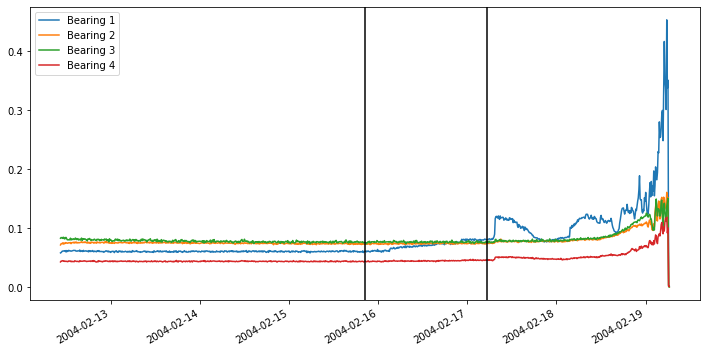

In [3]:
# 전체 기간의 데이터 분포 확인
merged_data.plot(figsize = (12, 6))
plt.axvline(merged_data.index[int(len(merged_data) * 0.5)], c='black')
plt.axvline(merged_data.index[int(len(merged_data) * 0.7)], c='black')

### Step2. 데이터 Split

In [4]:
X_train = merged_data[merged_data['data_type'] == 'train'].iloc[:, :4]
y_train = merged_data[merged_data['data_type'] == 'train'].iloc[:, -2].values

X_test = merged_data[merged_data['data_type'] == 'test'].iloc[:, :4]
y_test = merged_data[merged_data['data_type'] == 'test'].iloc[:, -2].values

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (492, 4)
Test data shape: (492, 4)


### Step3. 데이터 정규화

In [5]:
# train 데이터를 기반으로 train/test 데이터에 대하여 standard scaling 적용 (평균 0, 분산 1) 
scaler = StandardScaler()
scaler = scaler.fit(X_train)

In [6]:
X_train = pd.DataFrame(scaler.transform(X_train), 
                       columns=X_train.columns, 
                       index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), 
                      columns=X_test.columns, 
                      index=X_test.index)

---

# __<br> 2. 밀도 기반 이상치 탐지 기법: LOF__

# __2-1. Local Oulier Factor__

### Local Outlier Factor (LOF)
>이상치 스코어를 산출할 떄 주변부 데이터의 밀도를 고려하고자 함

<img src="https://i.imgur.com/flXG1jT.jpg" width="450">

In [7]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

### Step 1. Train 데이터 기반 모델 적합

- LocalOutlierFactor 설명
    - n_neighbors: neighbors 개수. 디폴트 20
    - algorithm: nearest neighbors 계산 방법 ('auto', 'ball_tree', 'kd_tree', 'brute'}. 디폴트 'auto'
    - metric: distance 계산 방법. 디폴트 'minkowski'
    - novelty: True (for novelty detection - no oulier in train data), False (for outlier detection - ouliers in train data). 디폴트 False

In [8]:
# LOF 모델 적합
lof_model = LocalOutlierFactor(n_neighbors=5, novelty=True)
lof_model.fit(X_train)

LocalOutlierFactor(n_neighbors=5, novelty=True)

### Step 2. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출

In [14]:
# train/test 데이터의 LOF score 도출
lof_train = - 1.0 * lof_model.score_samples(X_train.values)
lof_test = - 1.0 * lof_model.score_samples(X_test.values)

/home/ubuntu/python3-venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/home/ubuntu/python3-venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Test Data')

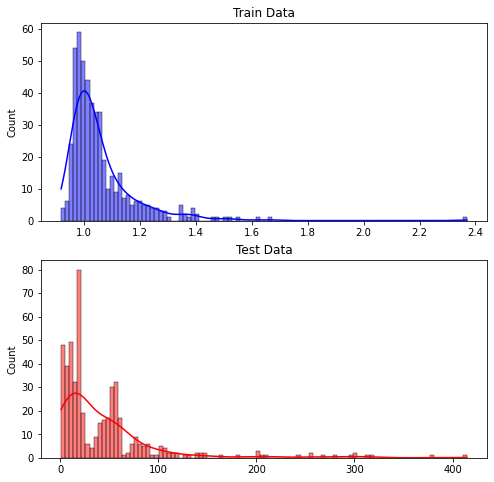

In [15]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.histplot(lof_train, bins=100, kde=True, color='blue', ax=ax1)
sns.histplot(lof_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [16]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0.5
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [17]:
# best threshold 도출
lof_best_threshold = search_best_threshold(lof_test, y_test, num_step=1000)

Best threshold:  15.0246
Best F1 Score: 0.9291


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [18]:
# 최종 결과 도출
lof_scores = pd.DataFrame(index=merged_data.index)
lof_scores['score'] = list(np.hstack([lof_train, lof_test]))
lof_scores['anomaly'] = lof_best_threshold < lof_scores['score']
lof_scores.head()

,score,anomaly
2004-02-12 10:32:39,2.369644,False
2004-02-12 10:42:39,1.671799,False
2004-02-12 10:52:39,1.250857,False
2004-02-12 11:02:39,1.218140,False
2004-02-12 11:12:39,1.346398,False


In [19]:
# anomaly score plot 도출
def draw_plot(scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(merged_data.index[int(len(merged_data) * 0.5)], c='orange', ls='--')
    
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

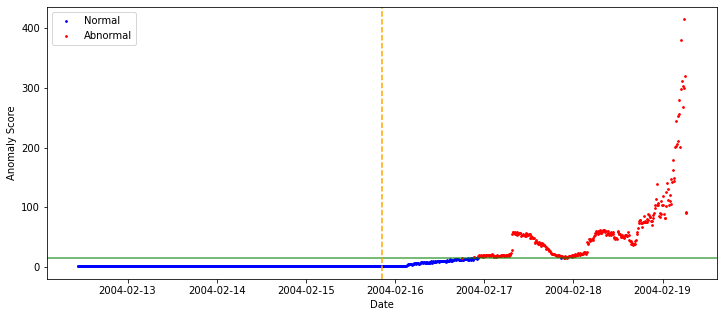

In [20]:
# 전체 데이터의 anomaly score 확인
draw_plot(lof_scores, lof_best_threshold)

In [21]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)
    
    return frr, far, f1

In [22]:
# F1 Score: 0.9291
frr, far, f1 = calculate_metric(y_test, lof_scores['anomaly'].iloc[int(len(merged_data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.2245  |  FAR: 0.0034  |  F1 Score: 0.9291


---